In [1]:
# declare the imports for building our neural network and displaying our data 
import tensorflow as tf
import PIL
import os
import h5py
import sys
import numpy as np
import pandas as pd
import random
import csv
import cv2
import fnmatch
import kerastuner as kt
import matplotlib.pyplot as plt 
from shutil import copyfile
from sklearn.model_selection import train_test_split
from numpy import asarray
from numpy import savetxt
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Activation, BatchNormalization
from keras.utils import np_utils
from matplotlib import image
from os import listdir
from sklearn.metrics import classification_report
from keras import optimizers
from kerastuner import RandomSearch


# set the input and outpout Dirs
data_dir = 'C:\\Users\davie\Desktop\Final_Project\FYP\HCurve'
Output = 'C:\\Users\davie\Desktop\Final_Project\FYP\Processed_Data\\'

In [2]:
# load and examine the shape of the data 
X_train = np.load(Output+'xtrain32x32.npy')
Y_train = np.load(Output+'ytrain32x32.npy')
X_test = np.load(Output+'xtest32x32.npy')
Y_test = np.load(Output+'ytest32x32.npy')
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(9818, 32, 32, 3)
(3273, 32, 32, 3)
(9818,)
(3273,)


In [3]:
# building the input vector from the 256x256 pixels
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalizing the data to help with the training
X_train /= 255
X_test /= 255

In [4]:
# one-hot encoding using keras
n_classes = 23
class_names = ['ABDMJ', 'Agen', 'Allaple', 'Autoit', 'Berbew', 'Bitman', 'Dinwod', 'Dorkbot', 
               'Dridex', 'Emotet', 'Fsysna', 'Hematite', 'InstallMonster', 'Oberal', 'Picsys', 
               'Salgorea', 'Scar', 'Sfone', 'Shifu', 'Socks', 'Sytro', 'Vilsel', 'Vobfus']
print("Shape before one-hot encoding: ", Y_train.shape)
Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_test = np_utils.to_categorical(Y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (9818,)
Shape after one-hot encoding:  (9818, 23)


In [5]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(9818, 32, 32, 3)
(3273, 32, 32, 3)
(9818, 23)
(3273, 23)


In [9]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    for i in range(hp.Int("num_layers", 2, 20)):
        model.add(
            layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(layers.Dense(23, activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [33]:
tuner = RandomSearch(build_model,objective="accuracy",max_trials=5,executions_per_trial=3,
                     overwrite=True,directory=Output,project_name="modelV9",)

In [34]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [35]:
tuner.search(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test))

Trial 5 Complete [00h 23m 48s]
accuracy: 0.9487675825754801

Best accuracy So Far: 0.9487675825754801
Total elapsed time: 01h 28m 37s
INFO:tensorflow:Oracle triggered exit


In [36]:
best_model = tuner.get_best_models(1)[0]

In [37]:
best_hps = tuner.get_best_hyperparameters(1)[0]

In [38]:
tuner.results_summary()

Results summary
Results in C:\Users\davie\Desktop\Final_Project\FYP\Processed_Data\modelV9
Showing 10 best trials
Objective(name='accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 9
units_0: 480
units_1: 352
learning_rate: 0.0001
units_2: 512
units_3: 64
units_4: 192
units_5: 64
units_6: 160
units_7: 320
units_8: 512
units_9: 192
units_10: 480
units_11: 192
units_12: 320
units_13: 160
units_14: 96
units_15: 288
units_16: 224
units_17: 512
units_18: 192
Score: 0.9487675825754801
Trial summary
Hyperparameters:
num_layers: 8
units_0: 96
units_1: 64
learning_rate: 0.001
units_2: 192
units_3: 320
units_4: 256
units_5: 256
units_6: 96
units_7: 96
units_8: 320
units_9: 352
units_10: 192
units_11: 448
units_12: 384
units_13: 320
units_14: 32
units_15: 288
units_16: 320
units_17: 32
units_18: 32
Score: 0.9210294087727865
Trial summary
Hyperparameters:
num_layers: 19
units_0: 192
units_1: 352
learning_rate: 0.01
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
uni

In [39]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
246/246 [==============================] - 26s 91ms/step - loss: 2.4021 - accuracy: 0.2765 - val_loss: 1.8173 - val_accuracy: 0.4695
Epoch 2/50
246/246 [==============================] - 21s 84ms/step - loss: 1.5442 - accuracy: 0.5246 - val_loss: 1.4665 - val_accuracy: 0.5402
Epoch 3/50
246/246 [==============================] - 20s 83ms/step - loss: 1.1310 - accuracy: 0.6529 - val_loss: 0.9857 - val_accuracy: 0.7118
Epoch 4/50
246/246 [==============================] - 21s 85ms/step - loss: 0.9128 - accuracy: 0.7264 - val_loss: 0.8974 - val_accuracy: 0.7495
Epoch 5/50
246/246 [==============================] - 21s 85ms/step - loss: 0.7955 - accuracy: 0.7602 - val_loss: 0.7743 - val_accuracy: 0.8055
Epoch 6/50
246/246 [==============================] - 21s 85ms/step - loss: 0.6600 - accuracy: 0.8122 - val_loss: 0.7247 - val_accuracy: 0.8070
Epoch 7/50
246/246 [==============================] - 21s 86ms/step - loss: 0.6195 - accuracy: 0.8212 - val_loss: 0.6625 - val_accuracy:

In [40]:
model.fit(X_train, Y_train, epochs=best_epoch)

Epoch 1/46
307/307 [==============================] - 24s 78ms/step - loss: 0.1567 - accuracy: 0.9594
Epoch 2/46
307/307 [==============================] - 24s 77ms/step - loss: 0.1293 - accuracy: 0.9647
Epoch 3/46
307/307 [==============================] - 24s 77ms/step - loss: 0.1387 - accuracy: 0.96170s - loss:
Epoch 4/46
307/307 [==============================] - 23s 76ms/step - loss: 0.1181 - accuracy: 0.9645
Epoch 5/46
307/307 [==============================] - 24s 77ms/step - loss: 0.0938 - accuracy: 0.9733
Epoch 6/46
307/307 [==============================] - 24s 78ms/step - loss: 0.1087 - accuracy: 0.9689
Epoch 7/46
307/307 [==============================] - 24s 79ms/step - loss: 0.0946 - accuracy: 0.9717
Epoch 8/46
307/307 [==============================] - 24s 77ms/step - loss: 0.1255 - accuracy: 0.9617
Epoch 9/46
307/307 [==============================] - 24s 79ms/step - loss: 0.0898 - accuracy: 0.9746
Epoch 10/46
307/307 [==============================] - 24s 77ms/step - l

In [41]:
# evaluate the model and print the score to screen 
trainingscores = model.evaluate(X_train, Y_train, verbose=0)
testingscores = model.evaluate(X_test, Y_test, verbose=0)
print("[INFO] evaluating network")
predictions = model.predict(X_test, batch_size=100)
print("training scores are below \n")
print("%s: %.2f%%" % (model.metrics_names[1], trainingscores[1]*100))
print("testing scores are below \n")
print("%s: %.2f%%" % (model.metrics_names[1], testingscores[1]*100))

[INFO] evaluating network
training scores are below 

accuracy: 98.93%
testing scores are below 

accuracy: 95.23%


In [42]:
print(classification_report(Y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=class_names))

                precision    recall  f1-score   support

         ABDMJ       1.00      0.96      0.98        27
          Agen       0.93      0.84      0.88       152
       Allaple       0.93      1.00      0.97        86
        Autoit       0.96      0.89      0.93       256
        Berbew       0.82      0.39      0.53        23
        Bitman       0.94      0.98      0.96       270
        Dinwod       0.97      1.00      0.98       249
       Dorkbot       0.89      0.89      0.89        28
        Dridex       1.00      1.00      1.00       129
        Emotet       0.97      0.83      0.89       112
        Fsysna       0.99      0.97      0.98       150
      Hematite       0.96      0.99      0.98       122
InstallMonster       0.94      0.91      0.93        75
        Oberal       1.00      0.93      0.96        56
        Picsys       0.92      1.00      0.96       130
      Salgorea       0.98      0.98      0.98       155
          Scar       0.77      0.70      0.73  

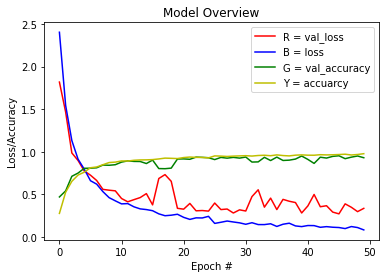

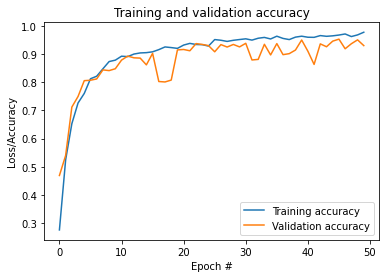

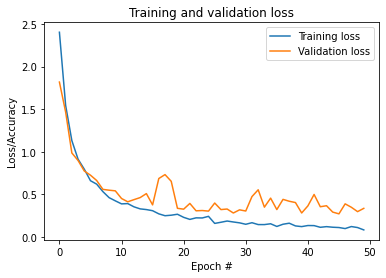

In [43]:
# Declare vars for the plotting of figures 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# overall model scoreing 
plt.plot(val_loss, 'r', loss, 'b', val_accuracy, 'g', accuracy, 'y')
label = 'R = val_loss', 'B = loss', 'G = val_accuracy', 'Y = accuarcy'
plt.title('Model Overview')
plt.legend(label)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.show()

# Training output 
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.show()

# testing output 
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.show()

In [44]:
model.save(Output + "modelReFIT9.h5")
print("Saved model to disk")

Saved model to disk
